### Basic use of the GIPL model

Before you begin, install:

```conda install -c conda-forge pymt pymt_gipl seaborn```


**GIPL** (Geophysical Institute Permafrost Laboratory) is an implicit finite difference one-dimensional heat flow numerical model. 

\begin{equation}
\frac{\partial H(x, t)}{\partial \tau}=\frac{\partial}{\partial x}\left(k(x, t) \frac{\partial t(x, \tau)}{\partial x}\right)
\end{equation}

The model uses fine vertical resolution grid which preserves the latent-heat effects in the phase transition zone, even under conditions of rapid or abrupt changes in the temperature fields. It includes upper boundary condition (usually air temperature), constant geothermal heat flux at the lower boundary, and initial temperature distribution with depth. The other inputs are snow depth, snow thermal conductivity, etc. The core output is temperature distributions at different depths.

**References**

Marchenko, S., Romanovsky, V., & Tipenko, G. (2008, June). Numerical modeling of spatial permafrost dynamics in Alaska. In Proceedings of the ninth international conference on permafrost (Vol. 29, pp. 1125-1130). Institute of Northern Engineering, University of Alaska Fairbanks.

Jafarov, E. E., Marchenko, S. S., and Romanovsky, V. E.: Numerical modeling of permafrost dynamics in Alaska using a high spatial resolution dataset, The Cryosphere, 6, 613-624, https://doi.org/10.5194/tc-6-613-2012, 2012.

----------------
Some libs should be imported.

**pymt.models** is required.

**others** are used for implementing and plotting

In [1]:
import pymt.models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
sns.set(style='whitegrid', font_scale= 1.2)

➡ models: FrostNumber, Ku, Hydrotrend, GIPL, Cem, Waves


**Import the GIPL model**

In [2]:
gipl = pymt.models.GIPL()
gipl.name

'The 1D GIPL Model'

Call the setup method to provide a default GIPL configuration file.

In [3]:
defaults = gipl.setup('.')
print(defaults)

('gipl_config.cfg', '/Users/mpiper/projects/GIPL-BMI-Fortran/Notebooks')


**Initialze the model**

In [4]:
gipl.initialize('gipl_config.cfg')

**Get the soil depth in the model**

It is used for plotting.

In [5]:
# List input and output variable names.
print(gipl.output_var_names)
print(gipl.input_var_names)

# Get soil depth: [unit: m]
depth = gipl.get_grid_z(2)
n_depth = int(len(depth))

('soil__temperature', 'model_soil_layer__count')
('land_surface_air__temperature', 'snowpack__depth', 'snow__thermal_conductivity', 'soil_water__volume_fraction', 'soil_unfrozen_water__a', 'soil_unfrozen_water__b')


**Get the length of forcing data**

In [6]:
# Get the length of forcing data
ntime = int(gipl.end_time)

# Define a variable to store soil temperature through the time period

tsoil = np.zeros((n_depth, ntime)) * np.nan

print('Final soil temperatures will be ', tsoil.shape)

Final soil temperatures will be  (176, 365)


**Run the model and plot the results**

Text(0.5, 1.0, 'Soil Surface (0.0m)')

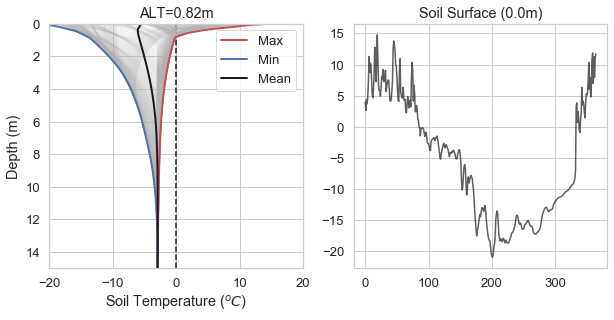

In [7]:
fig = plt.figure(figsize=[10,4.5])
ax = fig.add_subplot(1,2,1)
plt.ylim([15,0])
plt.xlim([-20,20])
plt.xlabel('Soil Temperature ($^oC$)')
plt.ylabel('Depth (m)')
plt.plot([0,0],[15,0],'k--')

for i in np.arange(int(ntime)):
    gipl.update() # Update Once
    tsoil[:,i] = gipl.get_value('soil__temperature') # save all temperature to a matrix
    plt.plot(tsoil[depth>=0,i], depth[depth>=0],color = [0.7,0.7,0.7], alpha = 0.1) # plot result of each time
    
plt.plot(tsoil[depth>=0,:].max(axis=1) , depth[depth>=0], 'r', linewidth = 2, label = 'Max' ) # Max
plt.plot(tsoil[depth>=0,:].min(axis=1) , depth[depth>=0], 'b', linewidth = 2, label = 'Min' ) # Min
plt.plot(tsoil[depth>=0,:].mean(axis=1), depth[depth>=0], 'k', linewidth = 2, label = 'Mean') # Mean
plt.legend()
plt.title('ALT='+str(depth[depth>=0][np.argmin(np.abs(tsoil[depth>=0,:].max(axis=1)))])+'m')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(tsoil[40,:], color = 'k', alpha = 0.7)
plt.title('Soil Surface (0.0m)')

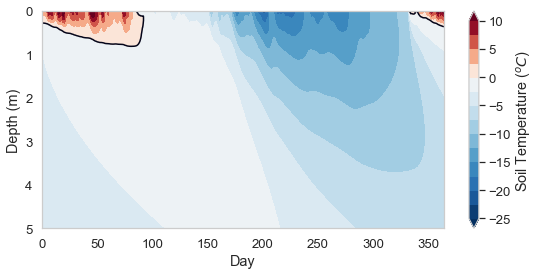

In [8]:
fig = plt.figure(figsize=[9,4])
divnorm = mcolors.DivergingNorm(vmin=-25., vcenter=0., vmax=10)
plt.contourf(np.arange(ntime), depth, tsoil, np.linspace(-25,10,15), 
             norm = divnorm,
             cmap="RdBu_r", extend = 'both')

plt.ylim([5,0])
cb = plt.colorbar()
plt.xlabel('Day')
plt.ylabel('Depth (m)')
cb.ax.set_ylabel('Soil Temperature ($^oC$)')

plt.contour(np.arange(ntime), depth, tsoil, [0]) # ZERO 

----------
### Try to simulate a warming (10%) of air temperature on the permafrost

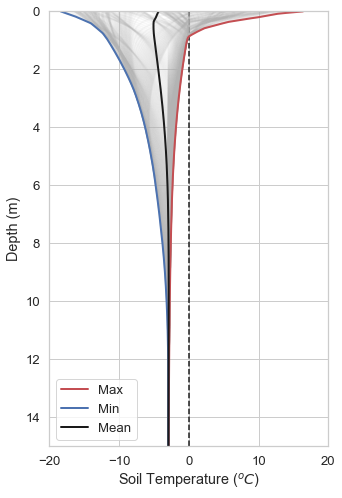

In [9]:
gipl.initialize('gipl_config.cfg')
fig = plt.figure(figsize=[5,8])
plt.ylim([15,0])
plt.xlim([-20,20])
plt.xlabel('Soil Temperature ($^oC$)')
plt.ylabel('Depth (m)')
plt.plot([0,0],[15,0],'k--')

for i in np.arange(int(ntime)):
    tair_raw = gipl.get_value('land_surface_air__temperature')
    gipl.set_value('land_surface_air__temperature', tair_raw + abs(tair_raw)*0.1)
    gipl.update()
    tsoil[:,i] = gipl.get_value('soil__temperature')
    plt.plot(tsoil[depth>=0,i], depth[depth>=0],color = [0.7,0.7,0.7], alpha = 0.1)
    
plt.plot(tsoil[depth>=0,:].max(axis=1), depth[depth>=0], 'r', linewidth = 2, label = 'Max')
plt.plot(tsoil[depth>=0,:].min(axis=1), depth[depth>=0], 'b', linewidth = 2, label = 'Min')
plt.plot(tsoil[depth>=0,:].mean(axis=1), depth[depth>=0], 'k', linewidth = 2, label = 'Mean')
plt.legend()